In [1]:
%pip install torch_geometric
%pip install xgboost
%pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Taimur Moolji - CPSC 483 Final Project

The following is the code employed for my final project. A straight runthrough of this will function. All necessary imports and pip installs are present.

In [4]:
import torch
import torch_geometric
import numpy as np
import os
from torch_geometric.datasets import EllipticBitcoinDataset as elip
from torch_geometric.datasets import DGraphFin as dgraph
from torch_geometric.datasets import Flickr as flickr
from torch_geometric.utils import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import  average_precision_score, roc_auc_score
from torch_geometric.utils import to_dgl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
import time
from sklearn.metrics import f1_score, accuracy_score,precision_score,recall_score,average_precision_score,roc_auc_score,roc_curve
import warnings
from torch_geometric.datasets import Planetoid
# from GMAE.node_classification.model import GMAE_node as gmae
# from GMAE.node_classification.wrapper import MyDataset
# from GMAE.node_classification.data import *
# from GMAE.node_classification.regression import *


# Step 1: Data Download + EDA

In [5]:
root = os.getcwd()
elip_data  = elip(root = root + '/elip')
flickr_data = flickr(root = root+ '/flickr')
cora_data = Planetoid(root = root + '/cora', name ="cora")

## Pre-Processing

In [6]:
validation_ratio = 0.1
train_mask = elip_data.train_mask

train_idx, val_idx = train_test_split(range(len(train_mask)), test_size=validation_ratio, random_state=42)

val_mask = torch.zeros_like(train_mask, dtype=torch.bool)
val_mask[val_idx] = True
train_mask[val_idx] = False
elip_data.val_mask = val_mask
elip_data.train_mask = train_mask

modified_labels = torch.where(flickr_data.y == 5, torch.tensor(1), torch.tensor(0))
flickr_data.y = modified_labels

modified_labels = torch.where(cora_data.y == 6, torch.tensor(1), torch.tensor(0))
cora_data.y = modified_labels


## Relevant Features

### Flickr

In [7]:
data = flickr_data
print("# of Nodes:", data.x.shape[0])
print("# of Edges:", torch.sum(data.edge_index >= 0).item())
print("# of Classes:", data.num_classes)
print("# of Node Features:", data.num_node_features)
print("# of Edge Features:", data.num_edge_features)
print("Homophily:", round(homophily(data.edge_index, data.y), 2))



# of Nodes: 89250
# of Edges: 1799512
# of Classes: 7
# of Node Features: 500
# of Edge Features: 0
Homophily: 0.94


## Eliptic

In [8]:
data = elip_data
print("# of Nodes:", data.x.shape[0])
print("# of Edges:", torch.sum(data.edge_index >= 0).item())
print("# of Classes:", data.num_classes)
print("# of Node Features:", data.num_node_features)
print("# of Edge Features:", data.num_edge_features)
print("Homophily:", round(homophily(data.edge_index, data.y), 2))



# of Nodes: 203769
# of Edges: 468710
# of Classes: 2
# of Node Features: 165
# of Edge Features: 0
Homophily: 0.71


## Cora

In [5]:
data = cora_data
print("# of Nodes:", data.x.shape[0])
print("# of Edges:", torch.sum(data.edge_index >= 0).item())
print("# of Classes:", data.num_classes)
print("# of Node Features:", data.num_node_features)
print("# of Edge Features:", data.num_edge_features)
print("Homophily:", round(homophily(data.edge_index, data.y), 2))



# of Nodes: 2708
# of Edges: 21112
# of Classes: 7
# of Node Features: 1433
# of Edge Features: 0
Homophily: 0.81


## Degree Distribution (Log)

### Flickr

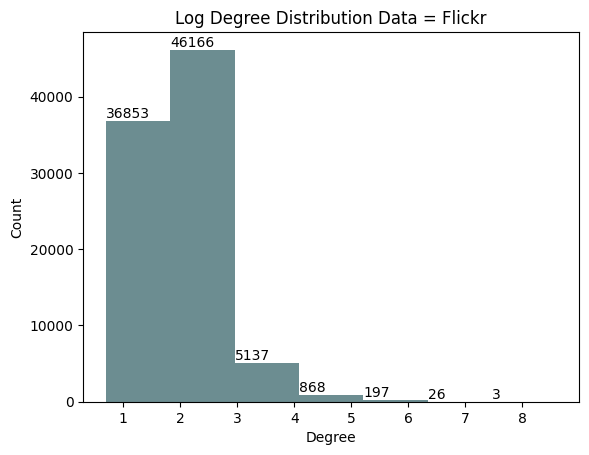

<Figure size 1000x600 with 0 Axes>

In [9]:
data = flickr_data
degree_values = np.log(degree(data.edge_index[1]) + 1)
bin_count, bin_edges, _ = plt.hist(degree_values, bins=7, color = '#6C8D91')

plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Log Degree Distribution Data = Flickr')

for i, count in enumerate(bin_count):
    if count > 0:
        plt.text(bin_edges[i], count, str(int(count)), ha='left', va='bottom')

plt.figure(figsize=(10, 6))
plt.show()



## Eliptic

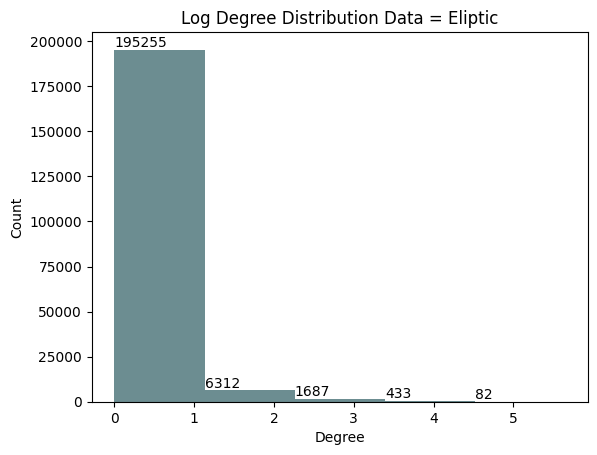

<Figure size 1000x600 with 0 Axes>

In [10]:
data = elip_data
degree_values = np.log(degree(elip_data.edge_index[1]) + 1)
bin_count, bin_edges, _ = plt.hist(degree_values, bins=5, color = '#6C8D91')


plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Log Degree Distribution Data = Eliptic')

for i, count in enumerate(bin_count):
    if count > 0:
        plt.text(bin_edges[i], count, str(int(count)), ha='left', va='bottom')

plt.figure(figsize=(10, 6))

plt.show()



### Cora

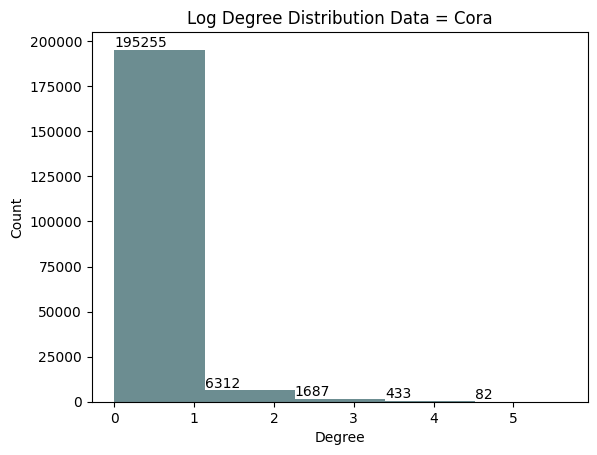

<Figure size 1000x600 with 0 Axes>

In [9]:
data = cora_data
degree_values = np.log(degree(elip_data.edge_index[1]) + 1)
bin_count, bin_edges, _ = plt.hist(degree_values, bins=5, color = '#6C8D91')


plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Log Degree Distribution Data = Cora')

for i, count in enumerate(bin_count):
    if count > 0:
        plt.text(bin_edges[i], count, str(int(count)), ha='left', va='bottom')

plt.figure(figsize=(10, 6))

plt.show()



## Histogram of Class Proportions

### Flickr

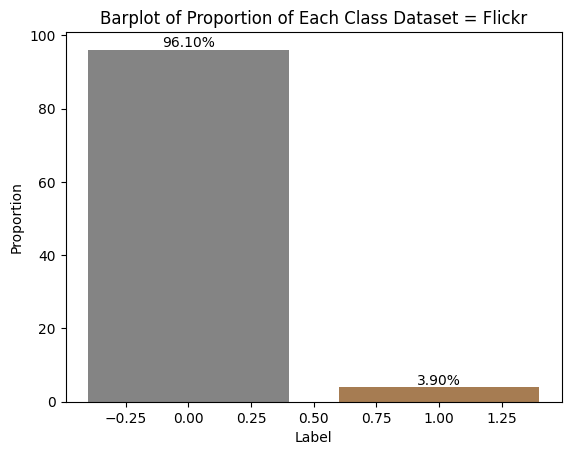

In [11]:
class_labels = flickr_data.y


unique_classes, class_counts = torch.unique(class_labels, return_counts=True)

unique_classes = unique_classes.numpy()
class_counts = class_counts.numpy()


colors = ['#848484', '#A67C52', '#6C8D91', '#B7A17E', '#A68E7C']


plt.bar(unique_classes, class_counts / sum(class_counts) * 100, color=colors)


plt.xlabel('Label')
plt.ylabel('Proportion')
plt.title('Barplot of Proportion of Each Class Dataset = Flickr')

for i, count in enumerate(class_counts / sum(class_counts) * 100):
    plt.text(unique_classes[i], count, f"{count:.2f}%", ha='center', va='bottom')


plt.show()



### Eliptic

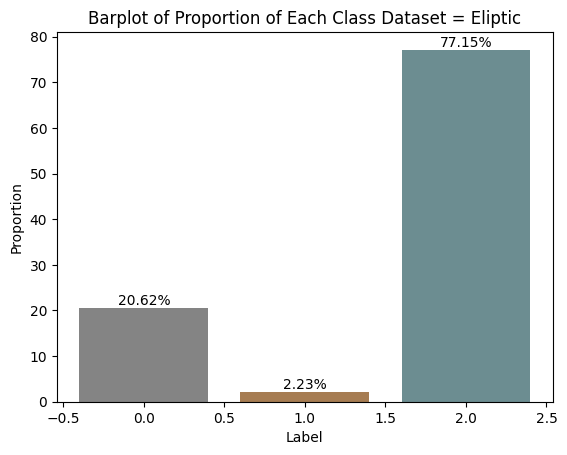

In [12]:
class_labels = elip_data.y

unique_classes, class_counts = torch.unique(class_labels, return_counts=True)

unique_classes = unique_classes.numpy()
class_counts = class_counts.numpy()


colors = ['#848484', '#A67C52', '#6C8D91', '#B7A17E', '#A68E7C']


plt.bar(unique_classes, class_counts / sum(class_counts) * 100, color=colors)


plt.xlabel('Label')
plt.ylabel('Proportion')
plt.title('Barplot of Proportion of Each Class Dataset = Eliptic')

for i, count in enumerate(class_counts / sum(class_counts) * 100):
    plt.text(unique_classes[i], count, f"{count:.2f}%", ha='center', va='bottom')


plt.show()


### Cora

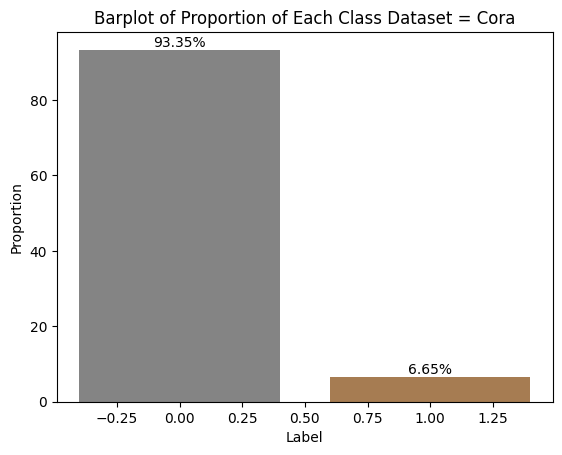

In [11]:
class_labels = cora_data.y

unique_classes, class_counts = torch.unique(class_labels, return_counts=True)

unique_classes = unique_classes.numpy()
class_counts = class_counts.numpy()


colors = ['#848484', '#A67C52', '#6C8D91', '#B7A17E', '#A68E7C']


plt.bar(unique_classes, class_counts / sum(class_counts) * 100, color=colors)


plt.xlabel('Label')
plt.ylabel('Proportion')
plt.title('Barplot of Proportion of Each Class Dataset = Cora')

for i, count in enumerate(class_counts / sum(class_counts) * 100):
    plt.text(unique_classes[i], count, f"{count:.2f}%", ha='center', va='bottom')


plt.show()


# Step 2: Pre-Processing

# Step 3: Data Pipeline

## Vanilla Models

In [7]:
# Helper function to implement standard models
def train_vanilla(x, y, model):
    ## TODO: Implement Test/Train Split
    model.fit(x, y)
    return model

# Logistic Regression
def train_logistic(dataset):
    return train_vanilla(dataset.x, dataset.y, LogisticRegression())

# Random Forest
def train_random_forest(dataset, n_estimators=100, max_depth=None):
    return train_vanilla(dataset.x, dataset.y, RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=483))

# Gradient Boosted Trees
def train_GBT(dataset, learning_rate=0.1, n_estimators=100, max_depth=3):
    return train_vanilla(dataset.x, dataset.y, GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, random_state=42))

# Extreme Gradient Boosted Trees
def train_xgboost(dataset, learning_rate=0.1, n_estimators=100, max_depth=3):
    return train_vanilla(dataset.x, dataset.y, xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, random_state=483))



def train_vanilla(x_train, y_train, model):
    model.fit(x_train, y_train)
    return model

def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    aucpr = average_precision_score(y_test, y_pred)
    return accuracy, aucpr

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Elip")
    # Train/Test Split using provided masks
    x_train, y_train = elip_data.x[elip_data.train_mask], elip_data.y[elip_data.train_mask]
    x_test, y_test = elip_data.x[elip_data.test_mask], elip_data.y[elip_data.test_mask]

    # Logistic Regression
    logistic_model = train_logistic(elip_data)
    logistic_accuracy, logistic_aucpr = evaluate_model(logistic_model, x_test, y_test)
    print(f"Logistic Regression - Accuracy: {logistic_accuracy:.4f} | AUC-PR: {logistic_aucpr:.4f}")

    # Extreme Gradient Boosted Trees
    xgboost_model = train_xgboost(elip_data)
    xgboost_accuracy, xgboost_aucpr = evaluate_model(xgboost_model, x_test, y_test)
    print(f"XGBoost - Accuracy: {xgboost_accuracy:.4f} | AUC-PR: {xgboost_aucpr:.4f}")


    print()



    print("Flickr")
    # Train/Test Split using provided masks
    x_train, y_train = flickr_data.x[flickr_data.train_mask], flickr_data.y[flickr_data.train_mask]
    x_test, y_test = flickr_data.x[flickr_data.test_mask], flickr_data.y[flickr_data.test_mask]

    # Logistic Regression
    logistic_model = train_logistic(flickr_data)
    logistic_accuracy, logistic_aucpr = evaluate_model(logistic_model, x_test, y_test)
    print(f"Logistic Regression - Accuracy: {logistic_accuracy:.4f} | AUC-PR: {logistic_aucpr:.4f}")

    # Extreme Gradient Boosted Trees
    xgboost_model = train_xgboost(flickr_data)
    xgboost_accuracy, xgboost_aucpr = evaluate_model(xgboost_model, x_test, y_test)
    print(f"XGBoost - Accuracy: {xgboost_accuracy:.4f} | AUC-PR: {xgboost_aucpr:.4f}")


    print()



    print("Cora")
    # Train/Test Split using provided masks
    x_train, y_train = cora_data.x[cora_data.train_mask], cora_data.y[cora_data.train_mask]
    x_test, y_test = cora_data.x[cora_data.test_mask], cora_data.y[cora_data.test_mask]

    # Logistic Regression
    logistic_model = train_logistic(cora_data)
    logistic_accuracy, logistic_aucpr = evaluate_model(logistic_model, x_test, y_test)
    print(f"Logistic Regression - Accuracy: {logistic_accuracy:.4f} | AUC-PR: {logistic_aucpr:.4f}")

    # Extreme Gradient Boosted Trees
    xgboost_model = train_xgboost(cora_data)
    xgboost_accuracy, xgboost_aucpr = evaluate_model(xgboost_model, x_test, y_test)
    print(f"XGBoost - Accuracy: {xgboost_accuracy:.4f} | AUC-PR: {xgboost_aucpr:.4f}")

Elip
Logistic Regression - Accuracy: 0.4155 | AUC-PR: 0.0953
XGBoost - Accuracy: 0.6943 | AUC-PR: 0.1171

Flickr
Logistic Regression - Accuracy: 0.9607 | AUC-PR: 0.0393
XGBoost - Accuracy: 0.9607 | AUC-PR: 0.0393

Cora
Logistic Regression - Accuracy: 0.9950 | AUC-PR: 0.9269
XGBoost - Accuracy: 0.9620 | AUC-PR: 0.4438


## MLP

In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MLPClassifier, self).__init__()

        self.ln_layers = nn.ModuleList()
        self.batchnorm_layers = nn.ModuleList()

        # Input layer to the first hidden layer
        self.ln_layers.append(nn.Linear(input_size, hidden_size))
        self.batchnorm_layers.append(nn.BatchNorm1d(hidden_size))

        # Hidden layers
        for _ in range(num_layers - 1):
            self.ln_layers.append(nn.Linear(hidden_size, hidden_size))
            self.batchnorm_layers.append(nn.BatchNorm1d(hidden_size))

        # Linear Map to number of classes
        self.ln_layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x, _):


        for ln_layer, batchnorm_layer in zip(self.ln_layers, self.batchnorm_layers):
            x = ln_layer(x)
            x = batchnorm_layer(x)
            x = F.relu(x)

        # Apply softmax for classification
        x = F.softmax(x, dim=1)

        return x


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPLinear(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MLPLinear, self).__init__()

        self.ln_layers = nn.ModuleList()
        self.batchnorm_layers = nn.ModuleList()

        # Input layer to the first hidden layer
        self.ln_layers.append(nn.Linear(input_size, hidden_size))
        self.batchnorm_layers.append(nn.BatchNorm1d(hidden_size))

        # Hidden layers
        for _ in range(num_layers - 1):
            self.ln_layers.append(nn.Linear(hidden_size, hidden_size))
            self.batchnorm_layers.append(nn.BatchNorm1d(hidden_size))

        # Linear Map to number of classes
        self.ln_final = nn.Linear(hidden_size, output_size)

    def forward(self, x, _):


        for ln_layer, batchnorm_layer in zip(self.ln_layers, self.batchnorm_layers):
            x = ln_layer(x)
            x = batchnorm_layer(x)
            x = F.relu(x)

        x = self.ln_final(x)

        return x


## Vanilla GCN

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()

        # Standard 2-layer GCN
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.ln = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, node_feature, edge_index):

        x = self.relu(self.conv1(node_feature, edge_index))
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.ln(x)

        # Softmax activation
        output = F.softmax(x, dim=1)

        return output


## Skip GCN

In [11]:
class SkipGCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(SkipGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.ln1 = torch.nn.Linear(num_features, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.ln2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.head = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = self.relu(x)
        intermediate_x = x

        x = self.conv2(x, edge_index)
        intermediate_x = self.ln2(intermediate_x)

        x = x + intermediate_x
        x = self.relu(x)

        x = self.head(x)

        x = F.softmax(x, dim=1)
        return x



# Step 3: Model Training

## Helper Functions

In [12]:
def get_num_classes(data):
  num_classes = len(data.y.unique())
  return num_classes

In [13]:
data = flickr_data
hidden_channels = 128
num_features = data.num_features
num_classes = get_num_classes(data)

model = GCN(num_features, hidden_channels, num_classes)

In [14]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

In [15]:

def train(model, data, optimizer, loss_fn):

    loss_local = 0
    model.train()
    optimizer.zero_grad()
    predictions = model(data.x, data.edge_index)
    loss_local += loss_fn(predictions[data.train_mask], data.y[data.train_mask])
    loss_local.backward()
    optimizer.step()
    loss_local = loss_local.item()

    return loss_local

In [16]:
@torch.no_grad()
def test(model, data):

    accuracy_list = [0, 0, 0, 0]

    model.eval()
    y_pred_probs = torch.zeros_like(data.y)
    y_pred_probs = torch.softmax(model(data.x, data.edge_index), dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)

    # Accuracy calculation
    accuracy_list[0] = torch.count_nonzero(torch.where(y_pred[data.train_mask] == data.y[data.train_mask], True, False)) / len(data.y[data.train_mask])
    accuracy_list[1] = torch.count_nonzero(torch.where(y_pred[data.val_mask] == data.y[data.val_mask], True, False)) / len(data.y[data.val_mask])
    accuracy_list[2] = torch.count_nonzero(torch.where(y_pred[data.test_mask] == data.y[data.test_mask], True, False)) / len(data.y[data.test_mask])

    # Precision-Recall curve and AUC-PR calculation
    if len(torch.unique(data.y[data.test_mask])) > 1:  
        precision, recall, _ = precision_recall_curve(data.y[data.test_mask].cpu(), y_pred_probs[data.test_mask, 1].cpu())
        auc_pr = auc(recall, precision)
        accuracy_list[3] = auc_pr
    else:
        accuracy_list[3] = 0.0  

    return accuracy_list


In [35]:
def evaluate(dataset, model, optimizer, loss_fn, epochs=50, print_every=10):
    best_val_acc = final_test_acc = best_auc_pr = 0

    for epoch in range(1, epochs + 1):
        loss = train(model, dataset, optimizer, loss_fn)
        train_acc, val_acc, test_acc, auc_pr = test(model, dataset)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            final_test_acc = test_acc
            best_auc_pr = auc_pr

        if epoch % print_every == 0:
            print("Epoch {:03d}/{:03d} | Loss: {:.4f} | Train Acc: {:.4f} | Val Acc: {:.4f} | Test Acc: {:.4f} | AUC-PR: {:.4f}"
                  .format(epoch, epochs, loss, train_acc, val_acc, test_acc, auc_pr))

    print("After {} epochs' training, the best test accuracy is {:.4f}".format(epochs, final_test_acc))
    print("The corresponding AUC-PR is {:.4f}".format(best_auc_pr))


import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_plot(dataset, model, optimizer, loss_fn, epochs=50, print_every=10):
    best_val_acc = final_test_acc = best_auc_pr = 0
    train_losses = []
    accuracies = []
    auc_pr_values = []

    for epoch in range(1, epochs + 1):
        train_loss = train(model, dataset, optimizer, loss_fn)
        train_acc, val_acc, test_acc, auc_pr = test(model, dataset)

        train_losses.append(train_loss)
        accuracies.append((train_acc, val_acc, test_acc))
        auc_pr_values.append(auc_pr)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            final_test_acc = test_acc
            best_auc_pr = auc_pr

        if epoch % print_every == 0:
            print("Epoch {:03d}/{:03d} | Loss: {:.4f} | Train Acc: {:.4f} | Val Acc: {:.4f} | Test Acc: {:.4f} | AUC-PR: {:.4f}"
                  .format(epoch, epochs, train_loss, train_acc, val_acc, test_acc, auc_pr))

    print("After {} epochs' training, the best test accuracy is {:.4f}".format(epochs, final_test_acc))
    print("The corresponding AUC-PR is {:.4f}".format(best_auc_pr))

    # Plotting
    epochs_range = np.arange(1, epochs + 1)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(epochs_range, [acc[0] for acc in accuracies], label='Train Acc', linestyle='dashed', color=color)
    ax1.plot(epochs_range, [acc[1] for acc in accuracies], label='Val Acc', linestyle='dashed', color=color, alpha=0.7)
    ax1.plot(epochs_range, [acc[2] for acc in accuracies], label='Test Acc', linestyle='dashed', color=color, alpha=0.4)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='lower right')
    ax1.set_xlabel('Epoch')

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.spines['right'].set_position(('outward', 60))
    ax2.set_ylabel('AUC-PR', color=color)
    ax2.plot(epochs_range, auc_pr_values, color=color)
    ax2.tick_params(axis='y', labelcolor=color)



    fig.tight_layout()
    plt.show()

def evaluate_with_loss(dataset, model, optimizer, loss_fn, epochs=50, print_every=10):
    best_val_acc = final_test_acc = best_auc_pr = 0
    train_losses = []
    accuracies = []
    auc_pr_values = []

    for epoch in range(1, epochs + 1):
        train_loss = train(model, dataset, optimizer, loss_fn)
        train_acc, val_acc, test_acc, auc_pr = test(model, dataset)

        train_losses.append(train_loss)
        accuracies.append((train_acc, val_acc, test_acc))
        auc_pr_values.append(auc_pr)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            final_test_acc = test_acc
            best_auc_pr = auc_pr

        if epoch % print_every == 0:
            print("Epoch {:03d}/{:03d} | Loss: {:.4f} | Train Acc: {:.4f} | Val Acc: {:.4f} | Test Acc: {:.4f} | AUC-PR: {:.4f}"
                  .format(epoch, epochs, train_loss, train_acc, val_acc, test_acc, auc_pr))

    print("After {} epochs' training, the best test accuracy is {:.4f}".format(epochs, final_test_acc))
    print("The corresponding AUC-PR is {:.4f}".format(best_auc_pr))

    # Plotting
    epochs_range = np.arange(1, epochs + 1)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(epochs_range, train_losses, label='Train Loss',color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='lower right')
    ax1.set_xlabel('Epoch')

    fig.tight_layout()
    plt.show()


# Vanilla GCN

Eliptic Dataset
Epoch 010/050 | Loss: 0.6647 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.2121
Epoch 020/050 | Loss: 0.6640 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.2931
Epoch 030/050 | Loss: 0.6591 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.3375
Epoch 040/050 | Loss: 0.6513 | Train Acc: 0.9009 | Val Acc: 0.2091 | Test Acc: 0.9416 | AUC-PR: 0.3571
Epoch 050/050 | Loss: 0.6408 | Train Acc: 0.9168 | Val Acc: 0.2088 | Test Acc: 0.9155 | AUC-PR: 0.3369
After 50 epochs' training, the best test accuracy is 0.9389
The corresponding AUC-PR is 0.3515


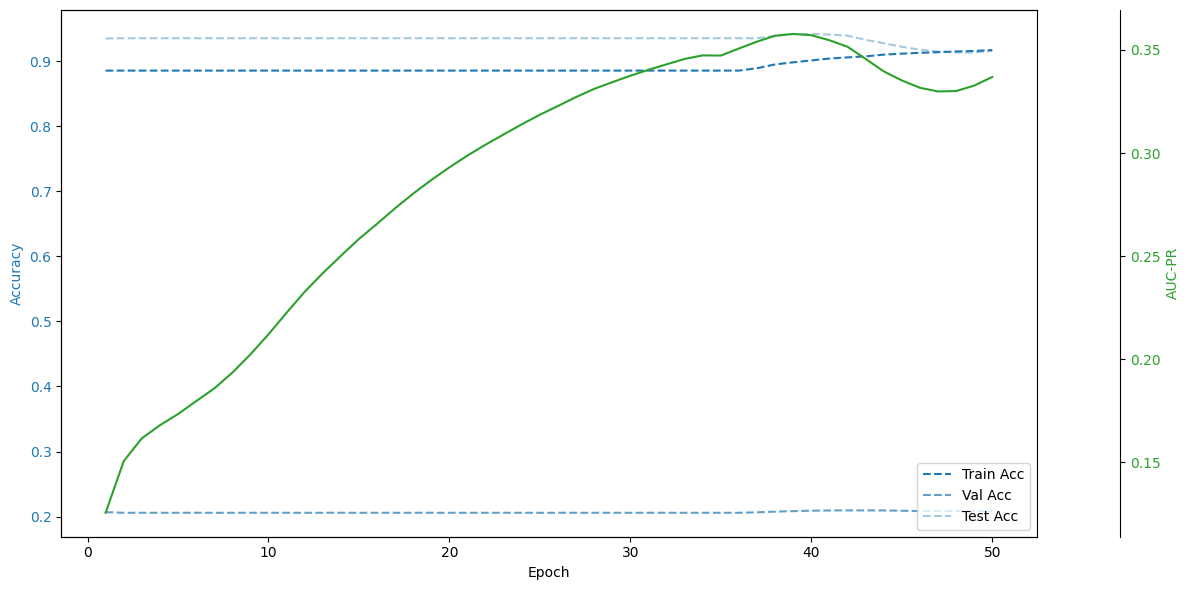

Epoch 010/050 | Loss: 0.6278 | Train Acc: 0.9261 | Val Acc: 0.2130 | Test Acc: 0.9414 | AUC-PR: 0.3939
Epoch 020/050 | Loss: 0.6201 | Train Acc: 0.9327 | Val Acc: 0.2149 | Test Acc: 0.9468 | AUC-PR: 0.4618
Epoch 030/050 | Loss: 0.6152 | Train Acc: 0.9374 | Val Acc: 0.2152 | Test Acc: 0.9460 | AUC-PR: 0.4549
Epoch 040/050 | Loss: 0.6115 | Train Acc: 0.9413 | Val Acc: 0.2158 | Test Acc: 0.9445 | AUC-PR: 0.4472
Epoch 050/050 | Loss: 0.6081 | Train Acc: 0.9450 | Val Acc: 0.2160 | Test Acc: 0.9460 | AUC-PR: 0.4706
After 50 epochs' training, the best test accuracy is 0.9460
The corresponding AUC-PR is 0.4706


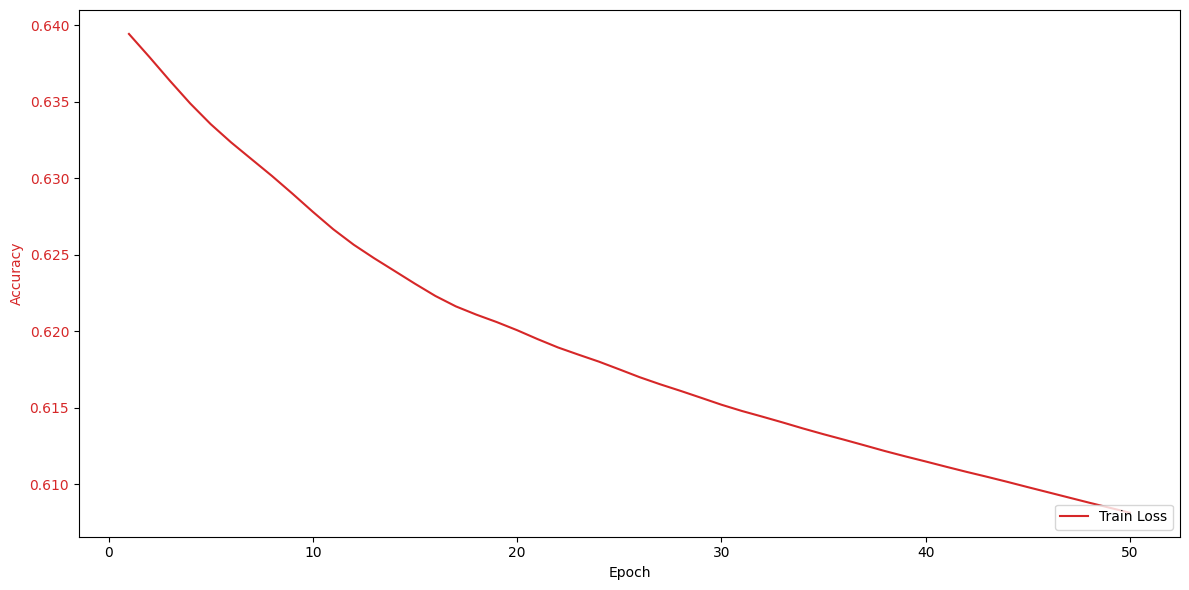

In [37]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

data = elip_data
hidden_channels = 200
num_features = data.num_features
num_classes = get_num_classes(data)

model = GCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-3)
loss_fn = nn.CrossEntropyLoss()

print("Eliptic Dataset")
evaluate_with_plot(elip_data, model, optimizer, loss_fn, epochs= 50)
evaluate_with_loss(elip_data, model, optimizer, loss_fn, epochs= 50)



Flickr Dataset
Epoch 010/050 | Loss: 0.7003 | Train Acc: 0.4019 | Val Acc: 0.3962 | Test Acc: 0.3985 | AUC-PR: 0.0354
Epoch 020/050 | Loss: 0.7003 | Train Acc: 0.4019 | Val Acc: 0.3962 | Test Acc: 0.3985 | AUC-PR: 0.0354
Epoch 030/050 | Loss: 0.7003 | Train Acc: 0.4019 | Val Acc: 0.3962 | Test Acc: 0.3985 | AUC-PR: 0.0354
Epoch 040/050 | Loss: 0.7003 | Train Acc: 0.4019 | Val Acc: 0.3962 | Test Acc: 0.3985 | AUC-PR: 0.0354
Epoch 050/050 | Loss: 0.7003 | Train Acc: 0.4019 | Val Acc: 0.3962 | Test Acc: 0.3985 | AUC-PR: 0.0354
After 50 epochs' training, the best test accuracy is 0.3985
The corresponding AUC-PR is 0.0354


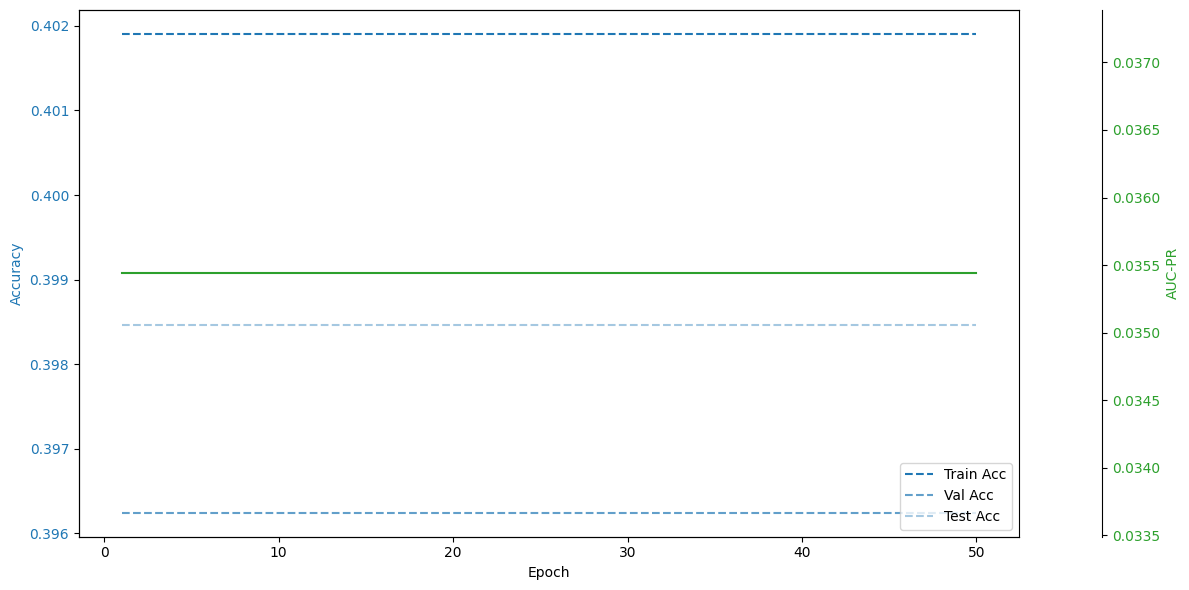

In [25]:
data = flickr_data
hidden_channels = 200
num_features = data.num_features
num_classes = 2

model1 = GCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Flickr Dataset")
evaluate_with_plot(flickr_data, model1, optimizer, loss_fn)

Cora Dataset
Epoch 010/050 | Loss: 0.4225 | Train Acc: 0.8571 | Val Acc: 0.9420 | Test Acc: 0.9370 | AUC-PR: 0.3831
Epoch 020/050 | Loss: 0.3679 | Train Acc: 0.9571 | Val Acc: 0.9480 | Test Acc: 0.9520 | AUC-PR: 0.6683
Epoch 030/050 | Loss: 0.3229 | Train Acc: 1.0000 | Val Acc: 0.9620 | Test Acc: 0.9610 | AUC-PR: 0.8147
Epoch 040/050 | Loss: 0.3137 | Train Acc: 1.0000 | Val Acc: 0.9720 | Test Acc: 0.9680 | AUC-PR: 0.8072
Epoch 050/050 | Loss: 0.3133 | Train Acc: 1.0000 | Val Acc: 0.9720 | Test Acc: 0.9670 | AUC-PR: 0.8064
After 50 epochs' training, the best test accuracy is 0.9630
The corresponding AUC-PR is 0.7936


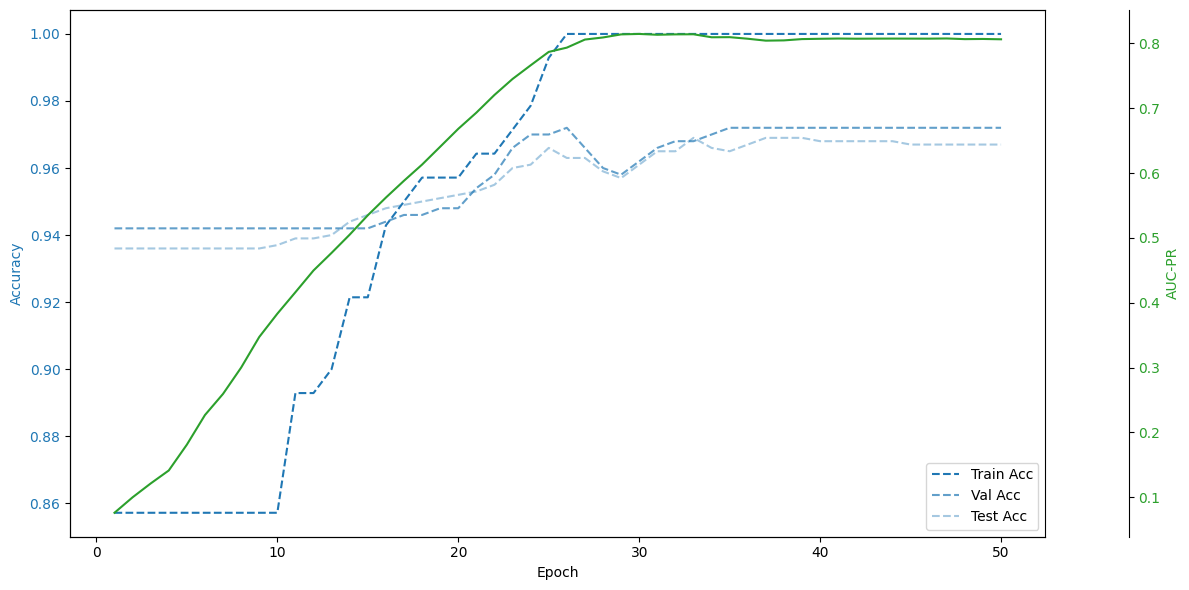

Epoch 010/050 | Loss: 0.3133
Epoch 020/050 | Loss: 0.3133
Epoch 030/050 | Loss: 0.3133
Epoch 040/050 | Loss: 0.3133
Epoch 050/050 | Loss: 0.3133


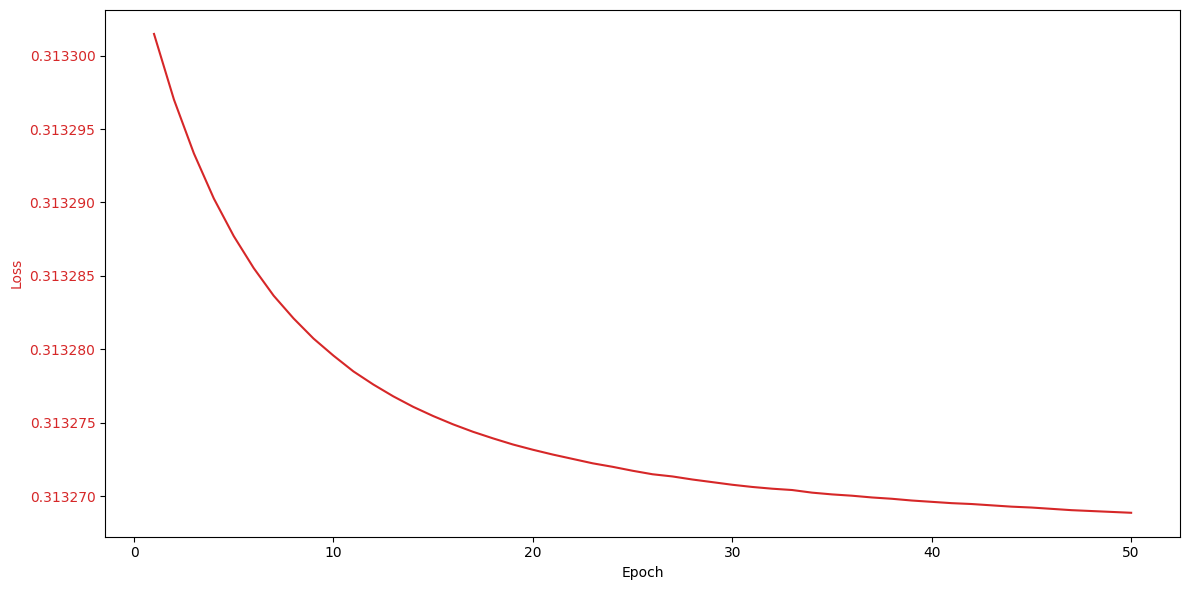

In [32]:
data = cora_data
hidden_channels = 200
num_features = data.num_features
num_classes = 2

model = GCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Cora Dataset")
evaluate_with_plot(cora_data, model, optimizer, loss_fn)
evaluate_with_loss(cora_data, model, optimizer, loss_fn)

# Skip GCN

Eliptic Dataset
Epoch 010/050 | Loss: 33.6941 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.2599
Epoch 020/050 | Loss: 33.6941 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.3192
Epoch 030/050 | Loss: 33.6941 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.3563
Epoch 040/050 | Loss: 33.6941 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.3732
Epoch 050/050 | Loss: 33.6941 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.3809
After 50 epochs' training, the best test accuracy is 0.9350
The corresponding AUC-PR is 0.1378


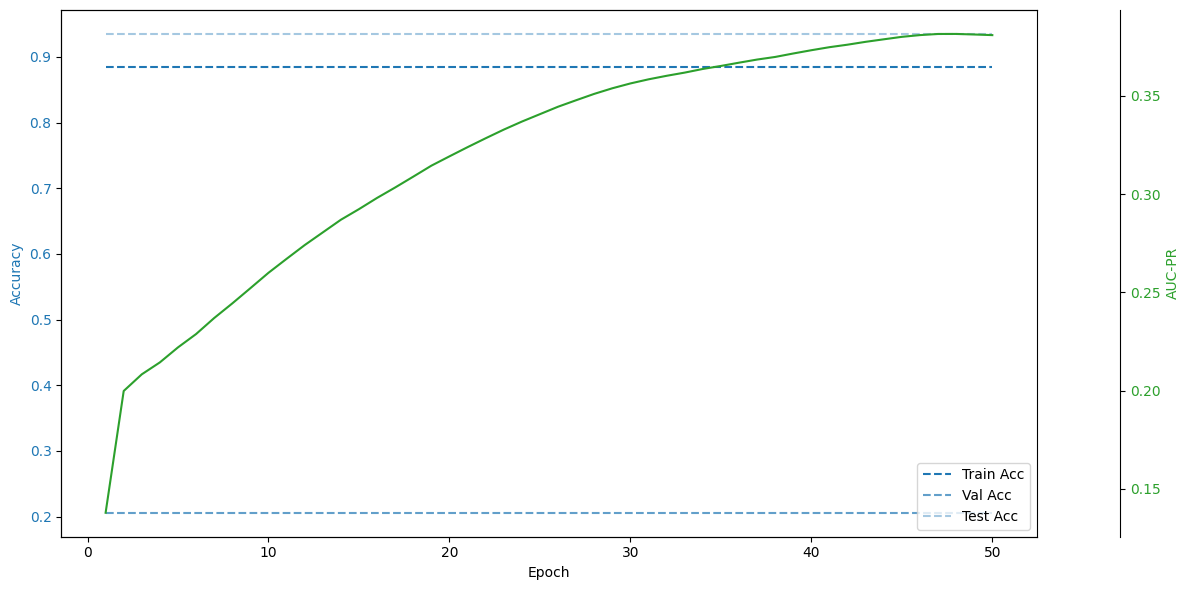

In [137]:
data = elip_data
hidden_channels = 200
num_features = data.num_features
num_classes = get_num_classes(data)

model = SkipGCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Eliptic Dataset")
evaluate_with_plot(data, model, optimizer, loss_fn)

Flickr Dataset
Epoch 010/050 | Loss: 33.6941 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
Epoch 020/050 | Loss: 33.6941 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
Epoch 030/050 | Loss: 33.6941 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
Epoch 040/050 | Loss: 33.6941 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
Epoch 050/050 | Loss: 33.6941 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
After 50 epochs' training, the best test accuracy is 0.9607
The corresponding AUC-PR is 0.0416


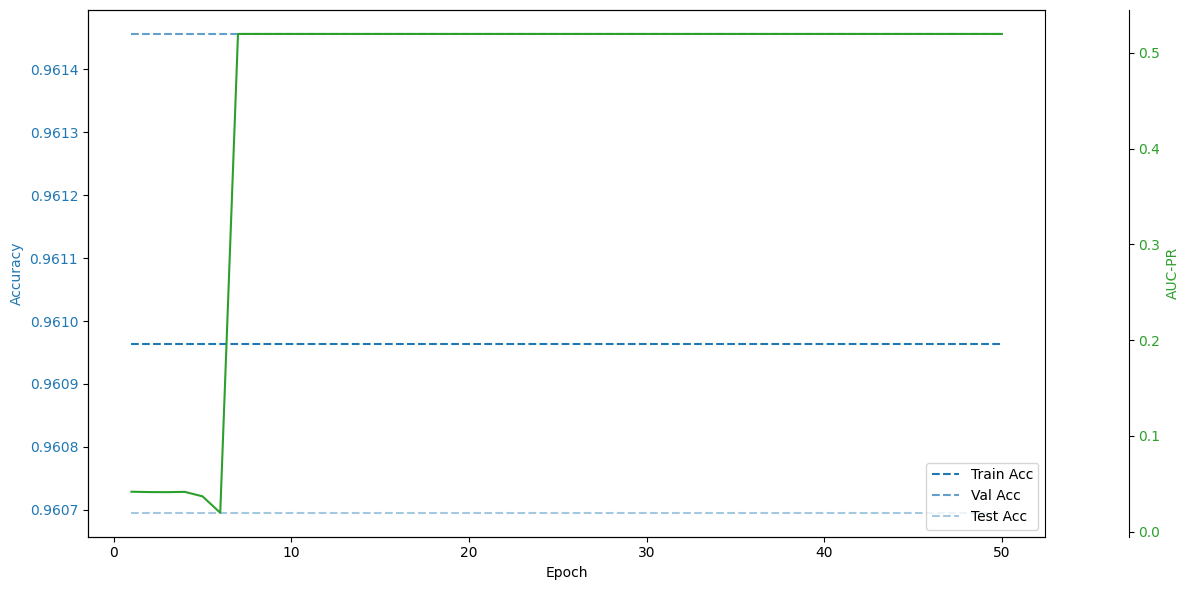

In [138]:
data = flickr_data
hidden_channels = 200
num_features = data.num_features
num_classes = 2

model = SkipGCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Flickr Dataset")
evaluate_with_plot(data, model, optimizer, loss_fn)

Cora Dataset
Epoch 010/050 | Loss: 0.4131 | Train Acc: 0.8929 | Val Acc: 0.9420 | Test Acc: 0.9390 | AUC-PR: 0.4348
Epoch 020/050 | Loss: 0.3445 | Train Acc: 0.9786 | Val Acc: 0.9660 | Test Acc: 0.9580 | AUC-PR: 0.7322
Epoch 030/050 | Loss: 0.3139 | Train Acc: 1.0000 | Val Acc: 0.9620 | Test Acc: 0.9650 | AUC-PR: 0.7998
Epoch 040/050 | Loss: 0.3134 | Train Acc: 1.0000 | Val Acc: 0.9660 | Test Acc: 0.9650 | AUC-PR: 0.7890
Epoch 050/050 | Loss: 0.3133 | Train Acc: 1.0000 | Val Acc: 0.9660 | Test Acc: 0.9640 | AUC-PR: 0.7838
After 50 epochs' training, the best test accuracy is 0.9630
The corresponding AUC-PR is 0.7524


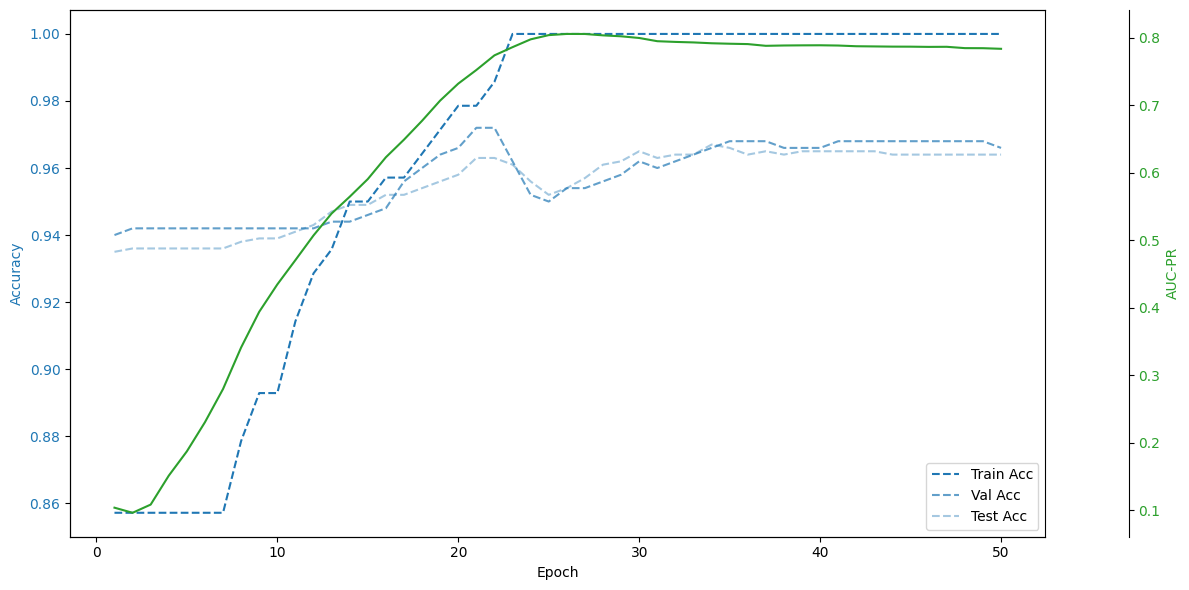

In [29]:
data = cora_data
hidden_channels = 200
num_features = data.num_features
num_classes = 2

model = SkipGCN(num_features, hidden_channels, num_classes)

optimizer = optim.Adam(model.parameters(), lr=2e-3)
loss_fn = nn.CrossEntropyLoss()

print("Cora Dataset")
evaluate_with_plot(cora_data, model, optimizer, loss_fn)

# Multilayer Perceptron

Eliptic Dataset
Epoch 010/050 | Loss: 33.6941 | Train Acc: 0.2609 | Val Acc: 0.0382 | Test Acc: 0.0156 | AUC-PR: 0.1151
Epoch 020/050 | Loss: 33.6941 | Train Acc: 0.3552 | Val Acc: 0.0560 | Test Acc: 0.0584 | AUC-PR: 0.4246
Epoch 030/050 | Loss: 33.6941 | Train Acc: 0.4695 | Val Acc: 0.0751 | Test Acc: 0.0793 | AUC-PR: 0.5961
Epoch 040/050 | Loss: 33.6941 | Train Acc: 0.5247 | Val Acc: 0.0824 | Test Acc: 0.0704 | AUC-PR: 0.4982
Epoch 050/050 | Loss: 33.6941 | Train Acc: 0.6101 | Val Acc: 0.0970 | Test Acc: 0.0953 | AUC-PR: 0.3816
After 50 epochs' training, the best test accuracy is 0.2493
The corresponding AUC-PR is 0.0660


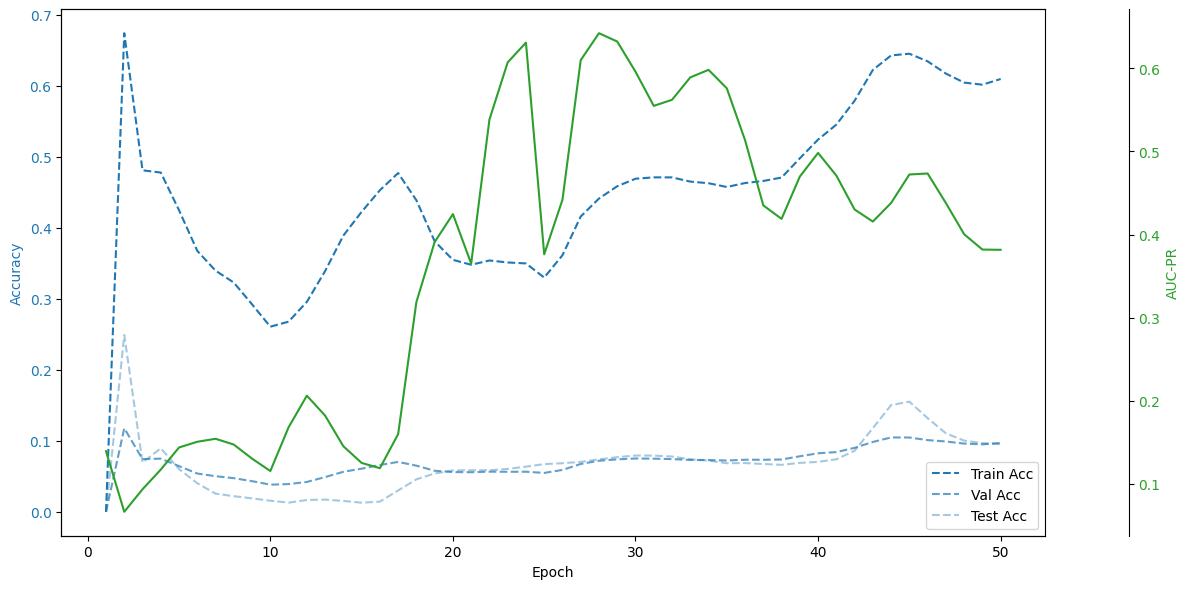

In [139]:
data = elip_data
hidden_channels = 200
num_features = data.num_features
num_classes = get_num_classes(data)

model = MLPClassifier(num_features, hidden_channels, 5, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Eliptic Dataset")
evaluate_with_plot(data, model, optimizer, loss_fn)

Flickr Dataset
Epoch 010/050 | Loss: 33.6941 | Train Acc: 0.0127 | Val Acc: 0.0141 | Test Acc: 0.0125 | AUC-PR: 0.0447
Epoch 020/050 | Loss: 33.6941 | Train Acc: 0.1572 | Val Acc: 0.1302 | Test Acc: 0.1313 | AUC-PR: 0.0602
Epoch 030/050 | Loss: 33.6941 | Train Acc: 0.4615 | Val Acc: 0.4280 | Test Acc: 0.4304 | AUC-PR: 0.0498
Epoch 040/050 | Loss: 33.6941 | Train Acc: 0.4104 | Val Acc: 0.3518 | Test Acc: 0.3537 | AUC-PR: 0.0485
Epoch 050/050 | Loss: 33.6941 | Train Acc: 0.5054 | Val Acc: 0.4434 | Test Acc: 0.4383 | AUC-PR: 0.0443
After 50 epochs' training, the best test accuracy is 0.9490
The corresponding AUC-PR is 0.0385


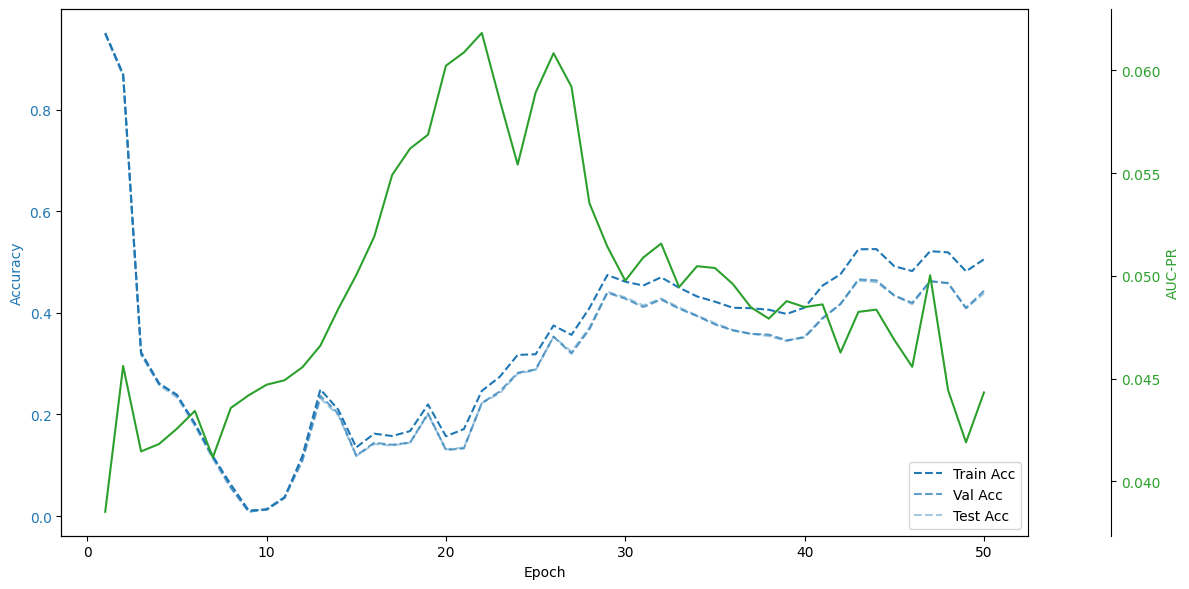

In [140]:
data = flickr_data
hidden_channels = 200
num_features = data.num_features
num_classes = 2

model = MLPClassifier(num_features, hidden_channels, 5, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Flickr Dataset")
evaluate_with_plot(data, model, optimizer, loss_fn)

Flickr Dataset
Epoch 010/050 | Loss: 5.2853 | Train Acc: 0.0000 | Val Acc: 0.0000 | Test Acc: 0.0000 | AUC-PR: 0.0702
Epoch 020/050 | Loss: 5.2457 | Train Acc: 0.0000 | Val Acc: 0.0000 | Test Acc: 0.0000 | AUC-PR: 0.0667
Epoch 030/050 | Loss: 5.1893 | Train Acc: 0.0000 | Val Acc: 0.0000 | Test Acc: 0.0000 | AUC-PR: 0.0704
Epoch 040/050 | Loss: 5.1291 | Train Acc: 0.0429 | Val Acc: 0.0000 | Test Acc: 0.0000 | AUC-PR: 0.0646
Epoch 050/050 | Loss: 5.0684 | Train Acc: 0.2571 | Val Acc: 0.0000 | Test Acc: 0.0000 | AUC-PR: 0.0747
After 50 epochs' training, the best test accuracy is 0.0000
The corresponding AUC-PR is 0.0000


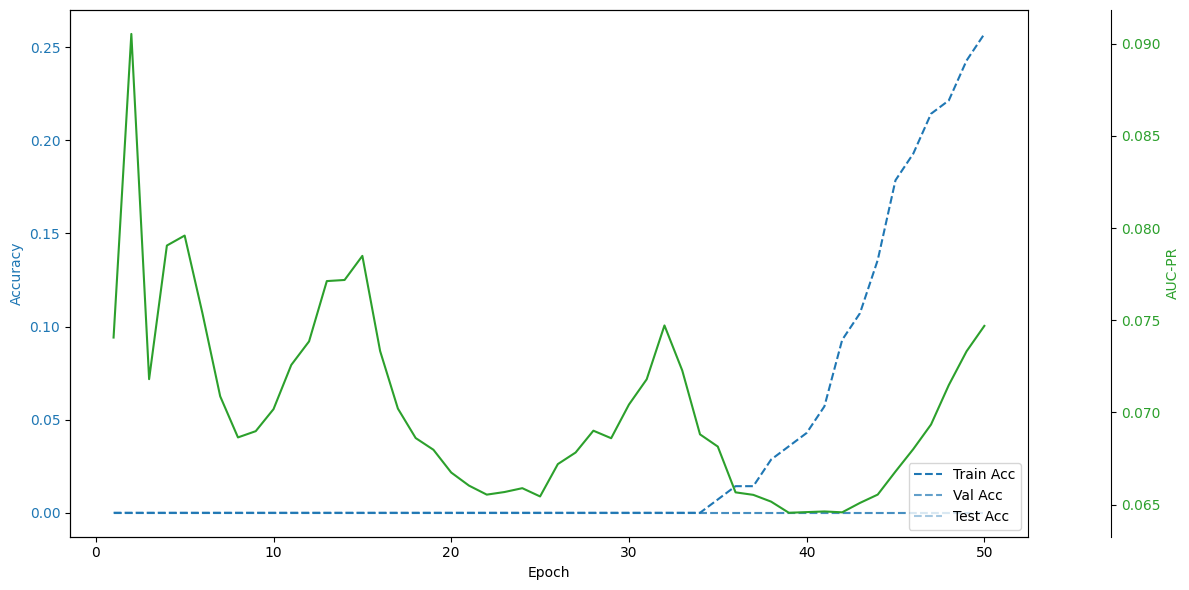

In [61]:
data = cora_data
hidden_channels = 200
num_features = data.num_features
num_classes = 2

model = MLPClassifier(num_features, hidden_channels, 5, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Flickr Dataset")
evaluate_with_plot(data, model, optimizer, loss_fn)

# SVDAE

## Class Defintions

In [19]:
import torch.sparse

class InnerProductDecoder(nn.Module):
    """Decoder model layer for link prediction."""
    def forward(self, z, start, stop, activation=None):
        """Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        z = z[start:stop]
        adj = torch.matmul(z, z.t())

        return activation(adj)

class SVDAE(nn.Module):
    def __init__(self,
                 num_layers,
                 in_feats,
                 n_hidden,
                 n_classes,
                 activation,
                 dropout,
                 n):
        super(SVDAE, self).__init__()
        self.A_encoder = MLPLinear(in_feats, n_hidden, num_layers, n_classes)
        self.A_decoder = MLPLinear(n_classes, n_hidden, num_layers, in_feats)
        self.S_encoder = GCN(in_feats, n_hidden, n_classes)
        self.Fusion = nn.ModuleList()
        self.Fusion.append( nn.Sequential(nn.Linear(n_classes*2, n_hidden),
                          nn.ReLU(inplace=True)))

        # output layer
        self.Fusion.append(nn.Linear(n_hidden, n_classes))
        self.dropout = nn.Dropout(p=dropout)
        self.InnerProducter = InnerProductDecoder()

    def forward(self, edge_index , features, n):
        A_z=self.A_encoder(edge_index, features)
        S_z = self.S_encoder(edge_index, features)
        Z = torch.add(A_z, S_z)
        A_recon = self.A_decoder(Z, _)

        #Sample n% of the adjacency matrix to prevent blowing out ram

        start_idx = torch.randint(0, Z.size(0) - 1000, (1,))
        end_idx = start_idx + 1000
        S_recon=self.InnerProducter(S_z, start_idx, end_idx ,activation=torch.sigmoid)
        return A_z,S_z, A_recon, S_recon, start_idx, end_idx

In [20]:
n_hidden = 1
dropout = 0.5
num_features = elip_data.num_features
model = SVDAE(
            num_layers = 1,
            in_feats = num_features,
            n_hidden = n_hidden,
            n_classes = elip_data.num_classes,
            activation = nn.ReLU(inplace=True),
            dropout = dropout,
            n = 0.1)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [21]:
def init_center_dual(n_hidden, model, data, eps=0.001):
    """Initialize hypersphere center c as the mean from an initial forward pass on the data."""
    c_A = torch.zeros(n_hidden,)
    c_S = torch.zeros(n_hidden)

    model.eval()
    with torch.no_grad():
        #data = data.to(device)
        outputs_A, outputs_S, rec, re_adj, start, end = model(data.x, data.edge_index, 0.1)

        # get the inputs of the batch
        n_samples_A = outputs_A.shape[0]
        c_A = torch.sum(outputs_A, dim=0)
        n_samples_S = outputs_S.shape[0]
        c_S = torch.sum(outputs_S, dim=0)

    c_A /= n_samples_A
    c_S /= n_samples_S

    # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.
    c_A[(abs(c_A) < eps) & (c_A < 0)] = -eps
    c_A[(abs(c_A) < eps) & (c_A > 0)] = eps

    c_S[(abs(c_S) < eps) & (c_S < 0)] = -eps
    c_S[(abs(c_S) < eps) & (c_S > 0)] = eps

    return c_A, c_S, start, end

In [22]:
##loss of Dual-SVDAE
def loss_function_dualAE(beta, nu1, nu2, rec,re_adj,adj,data,data_center_A, data_center_S, outputs_A,outputs_S,radius_A=0,radius_S = 0, mask = None):
    dist_A, scores_A = anomaly_score(data_center_A, outputs_A, mask, radius_A )
    dist_S, scores_S = anomaly_score(data_center_S, outputs_S, mask, radius_S )
    scores_A = F.normalize(scores_A, p=1, dim=0 )
    scores_S = F.normalize(scores_S, p=1, dim=0)
    scores = beta * scores_A + (1 - beta) * scores_S
    loss_A = radius_A ** 2 + (1 / nu1) * torch.mean(torch.max(torch.zeros_like(scores_A), scores_A)) + torch.mean((rec - data) ** 2)  #
    loss_S = radius_S ** 2 + (1 / nu2) * torch.mean(torch.max(torch.zeros_like(scores_S), scores_S)) + torch.mean((re_adj - adj) ** 2)  #
    loss = beta * loss_A + (1 - beta) * loss_S
    return loss, dist_A, dist_S, scores

def anomaly_score(data_center,outputs, mask, radius=0):
    if mask == None:
        dist = torch.sum((outputs - data_center) ** 2, dim=1)
    else:
        dist = torch.sum((outputs[mask] - data_center) ** 2, dim=1)
    scores = dist - radius ** 2
    return dist,scores


In [23]:
def generate_approx_adj(data, start, end, n):
  adj_matrix_sparse = coalesce(data.edge_index, None, num_nodes=data[0].num_nodes)
  adj_matrix_sparse = adj_matrix_sparse[0]

  mask = (adj_matrix_sparse[0] >= start) & (adj_matrix_sparse[0] < end) & (adj_matrix_sparse[1] >= start) & (adj_matrix_sparse[1] < end)

  adj_matrix_sparse = adj_matrix_sparse[:, mask]

  adj_matrix_sparse[0] -= start
  adj_matrix_sparse[1] -= start

  edges = torch.tensor(list(zip(adj_matrix_sparse[0], adj_matrix_sparse[1])))

  # Create the adjacency matrix directly using tensor operations

  samp = 1000
  adjacency_matrix = torch.zeros((samp, samp))
  if edges.shape[0] != 0 :
    adjacency_matrix[edges[0], edges[1]] = 1

  return adjacency_matrix

In [24]:
def train_SVDAE(data, model, optimizer, beta, nu1, nu2, data_center_A, data_center_S, radius_A,
                                                  radius_S):
  loss = 0
  model.train()
  optimizer.zero_grad()


  outputs_A, outputs_S, rec, re_adj, start, end = model(data.x, data.edge_index, 0.1)
  adj = generate_approx_adj(data, start, end, 0.1)


  loss, dist_A, dist_S, score = loss_function_dualAE(beta, nu1, nu2, rec, re_adj, adj, data.x,
                                                  data_center_A, data_center_S, outputs_A, outputs_S, radius_A,
                                                  radius_S, data.train_mask)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss, dist_A, dist_S, score


In [25]:
def thresholding(recon_error,threshold):
    ano_pred=np.zeros(recon_error.shape[0])
    for i in range(recon_error.shape[0]):
        if recon_error[i]>threshold:
            ano_pred[i]=1
    return ano_pred

@torch.no_grad()
def test_SVDAE(model, data, beta, nu1, nu2, data_center_A, data_center_S, radius_A,
                                                  radius_S, p = False):
  accuracy_list = [0, 0, 0, 0, 0, 0]

  outputs_A, outputs_S, rec, re_adj, start, end = model(data.x, data.edge_index, 0.1)
  adj = generate_approx_adj(data, start, end, 0.1)

  loss, _, _, scores = loss_function_dualAE(beta, nu1, nu2, rec, re_adj, adj, data.x,
                                                  data_center_A, data_center_S, outputs_A, outputs_S, radius_A,
                                                  radius_S)

  scores = scores.detach().numpy()
  # print(scores)
  pred = torch.tensor(thresholding(scores, 0))
  # print(torch.sum(pred))


  # print(radius_S)

  # Accuracy calculation
  accuracy_list[0] = torch.count_nonzero(torch.where(pred[data.train_mask] == data.y[data.train_mask], True, False)) / len(data.y[data.train_mask])
  accuracy_list[1] = torch.count_nonzero(torch.where(pred[data.val_mask] == data.y[data.val_mask], True, False)) / len(data.y[data.val_mask])
  accuracy_list[2] = torch.count_nonzero(torch.where(pred[data.test_mask] == data.y[data.test_mask], True, False)) / len(data.y[data.test_mask])

  # Precision-Recall curve and AUC-PR calculation
  if len(torch.unique(data.y[data.test_mask])) > 1:  # Check if it's a binary classification problem
      recall = recall_score(data.y[data.test_mask], pred[data.test_mask])
      precision = precision_score(data.y[data.test_mask], pred[data.test_mask])
      f1 = f1_score(data.y[data.test_mask], pred[data.test_mask])
      accuracy_list[3] = recall
      accuracy_list[4] = precision
      accuracy_list[5] = f1
  else:
      accuracy_list[3] = 0.0  # Set AUC-PR to 0 for single-class problems

  return accuracy_list

In [26]:
def get_radius(dist: torch.Tensor, nu: float):
    """Optimally solve for radius R via the (1-nu)-quantile of distances."""
    radius=np.quantile(np.sqrt(dist.clone().data.cpu().numpy()), 1 - nu)
    if radius<0.1:
        radius=0.1
    return radius

In [27]:
def evaluate_SVDAE(data, model, optimizer, n_hidden, beta, nu1, nu2, epochs, print_every=10):
    data_center_A, data_center_S, start, end = init_center_dual(n_hidden, model, data)
    radius_A = torch.tensor(0)
    radius_S = torch.tensor(0)

    for epoch in range(1, epochs + 1):
        pr = (epoch == epochs)
        loss, dist_A, dist_S, score = train_SVDAE(data, model, optimizer, beta, nu1, nu2, data_center_A, data_center_S, radius_A, radius_S)
        train_acc, val_acc, test_acc, recall, precision, f1 = test_SVDAE(model, data, beta, nu1, nu2, data_center_A, data_center_S, radius_A, radius_S, pr)

        if epoch % print_every == 0:
              print("Epoch {:03d}/{:03d}".format(epoch, epochs))
        #     print("Epoch {:03d}/{:03d} | Loss: {:.4f} | Train Acc: {:.4f} | Val Acc: {:.4f} | Test Acc: {:.4f} | Recall: {:.4f} | Precision: {:.4f} | F1: {:.4f}"
        #           .format(epoch, epochs, loss, train_acc, val_acc, test_acc, recall, precision, f1))

        radius_A = torch.tensor(get_radius(dist_A, nu1))
        radius_S = torch.tensor(get_radius(dist_S, nu2))




    return score, radius_A, radius_S

## Evaluated on Flicker

In [151]:
data = flickr_data
n_hidden = 256
dropout = 0.5
num_features = data.num_features
model = SVDAE(
            num_layers = 1,
            in_feats = num_features,
            n_hidden = n_hidden,
            n_classes = data.num_classes,
            activation = nn.ReLU(inplace=True),
            dropout = dropout,
            n=0.1)
optimizer = optim.Adam(model.parameters(), lr=2e-3)


print("Flickr Dataset")
score, ra, rs = evaluate_SVDAE(data, model, optimizer, hidden_channels, 0.9, 0.2, 0.2, 50, 1)

Flickr Dataset
Epoch 001/050
Epoch 002/050
Epoch 003/050
Epoch 004/050
Epoch 005/050
Epoch 006/050
Epoch 007/050
Epoch 008/050
Epoch 009/050
Epoch 010/050
Epoch 011/050
Epoch 012/050
Epoch 013/050
Epoch 014/050
Epoch 015/050
Epoch 016/050
Epoch 017/050
Epoch 018/050
Epoch 019/050
Epoch 020/050
Epoch 021/050
Epoch 022/050
Epoch 023/050
Epoch 024/050
Epoch 025/050
Epoch 026/050
Epoch 027/050
Epoch 028/050
Epoch 029/050
Epoch 030/050
Epoch 031/050
Epoch 032/050
Epoch 033/050
Epoch 034/050
Epoch 035/050
Epoch 036/050
Epoch 037/050
Epoch 038/050
Epoch 039/050
Epoch 040/050
Epoch 041/050
Epoch 042/050
Epoch 043/050
Epoch 044/050
Epoch 045/050
Epoch 046/050
Epoch 047/050
Epoch 048/050
Epoch 049/050
Epoch 050/050


In [51]:
data_center_A, data_center_S, start, end = init_center_dual(n_hidden, model, data)
beta = 0.9
nu1 = nu2 = 0.2

outputs_A, outputs_S, rec, re_adj, start, end = model(data.x, data.edge_index, 0.1)
adj = generate_approx_adj(data, start, end, 0.1)

loss, _, _, scores = loss_function_dualAE(beta, nu1, nu2, rec, re_adj, adj, data.x,
                                                  data_center_A, data_center_S, outputs_A, outputs_S, ra,
                                                  rs)

In [153]:
scores = scores.view(-1, 1)

# Concatenate along the second dimension (columns)
result = torch.cat((flickr_data.x, scores.detach()), dim=1)

In [154]:
flickr_data_mod = flickr(root = root+ '/flickr')
flickr_data_mod.x = result
modified_labels = torch.where(flickr_data_mod.y == 5, torch.tensor(1), torch.tensor(0))
flickr_data_mod.y = modified_labels

Flickr Dataset
Epoch 010/050 | Loss: 19.2646 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
Epoch 020/050 | Loss: 19.2646 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
Epoch 030/050 | Loss: 19.2646 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
Epoch 040/050 | Loss: 19.2646 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
Epoch 050/050 | Loss: 19.2646 | Train Acc: 0.9610 | Val Acc: 0.9615 | Test Acc: 0.9607 | AUC-PR: 0.5197
After 50 epochs' training, the best test accuracy is 0.9607
The corresponding AUC-PR is 0.0430


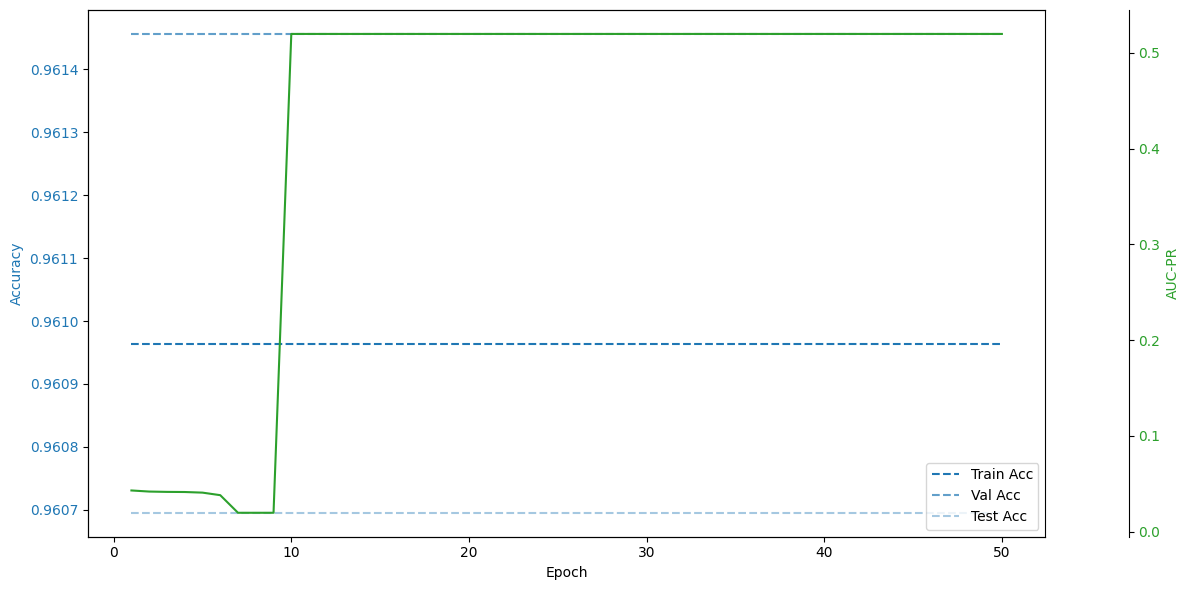

In [160]:
data = flickr_data_mod
hidden_channels = 200
num_features = data.num_features+1
num_classes = get_num_classes(data)

model2 = GCN(num_features, hidden_channels, num_classes)
optimizer2 = optim.Adam(model2.parameters(), lr=2e-3)
loss_fn = nn.CrossEntropyLoss()

optimizer2.zero_grad()

print("Flickr Dataset")
evaluate_with_plot(flickr_data_mod, model2, optimizer2, loss_fn)

## Evaluated on Eliptic

In [161]:
data = elip_data
n_hidden = 256
dropout = 0.5
num_features = data.num_features
model = SVDAE(
            num_layers = 1,
            in_feats = num_features,
            n_hidden = n_hidden,
            n_classes = data.num_classes,
            activation = nn.ReLU(inplace=True),
            dropout = dropout)
optimizer = optim.Adam(model.parameters(), lr=2e-3)


print("Elip Dataset")
score, ra, rs = evaluate_SVDAE(data, model, optimizer, hidden_channels, 0.9, 0.2, 0.2, 50, 1)

Elip Dataset
Epoch 001/050
Epoch 002/050
Epoch 003/050
Epoch 004/050
Epoch 005/050
Epoch 006/050
Epoch 007/050
Epoch 008/050
Epoch 009/050
Epoch 010/050
Epoch 011/050
Epoch 012/050
Epoch 013/050
Epoch 014/050
Epoch 015/050
Epoch 016/050
Epoch 017/050
Epoch 018/050
Epoch 019/050
Epoch 020/050
Epoch 021/050
Epoch 022/050
Epoch 023/050
Epoch 024/050
Epoch 025/050
Epoch 026/050
Epoch 027/050
Epoch 028/050
Epoch 029/050
Epoch 030/050
Epoch 031/050
Epoch 032/050
Epoch 033/050
Epoch 034/050
Epoch 035/050
Epoch 036/050
Epoch 037/050
Epoch 038/050
Epoch 039/050
Epoch 040/050
Epoch 041/050
Epoch 042/050
Epoch 043/050
Epoch 044/050
Epoch 045/050
Epoch 046/050
Epoch 047/050
Epoch 048/050
Epoch 049/050
Epoch 050/050


In [162]:
data = elip_data
data_center_A, data_center_S, start, end = init_center_dual(n_hidden, model, data)
beta = 0.9
nu1 = nu2 = 0.2

outputs_A, outputs_S, rec, re_adj, start, end = model(data.x, data.edge_index, 0.1)
adj = generate_approx_adj(data, start, end, 0.1)

loss, _, _, scores = loss_function_dualAE(beta, nu1, nu2, rec, re_adj, adj, data.x,
                                                  data_center_A, data_center_S, outputs_A, outputs_S, ra,
                                                  rs)
scores = scores.view(-1, 1)

# Concatenate along the second dimension (columns)
result2 = torch.cat((elip_data.x, scores.detach()), dim=1)
elip_data_mod = elip(root = root+ '/elip')
elip_data_mod.x = result2

validation_ratio = 0.1
train_mask = elip_data_mod.train_mask

train_idx, val_idx = train_test_split(range(len(train_mask)), test_size=validation_ratio, random_state=42)

val_mask = torch.zeros_like(train_mask, dtype=torch.bool)
val_mask[val_idx] = True
train_mask[val_idx] = False
elip_data_mod.val_mask = val_mask
elip_data_mod.train_mask = train_mask




Elip Dataset
Epoch 010/050 | Loss: 42.1371 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.2614
Epoch 020/050 | Loss: 42.1371 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.3064
Epoch 030/050 | Loss: 42.1371 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.3394
Epoch 040/050 | Loss: 42.1371 | Train Acc: 0.8853 | Val Acc: 0.2059 | Test Acc: 0.9350 | AUC-PR: 0.3562
Epoch 050/050 | Loss: 42.1371 | Train Acc: 0.9125 | Val Acc: 0.2112 | Test Acc: 0.9414 | AUC-PR: 0.3377
After 50 epochs' training, the best test accuracy is 0.9414
The corresponding AUC-PR is 0.3377


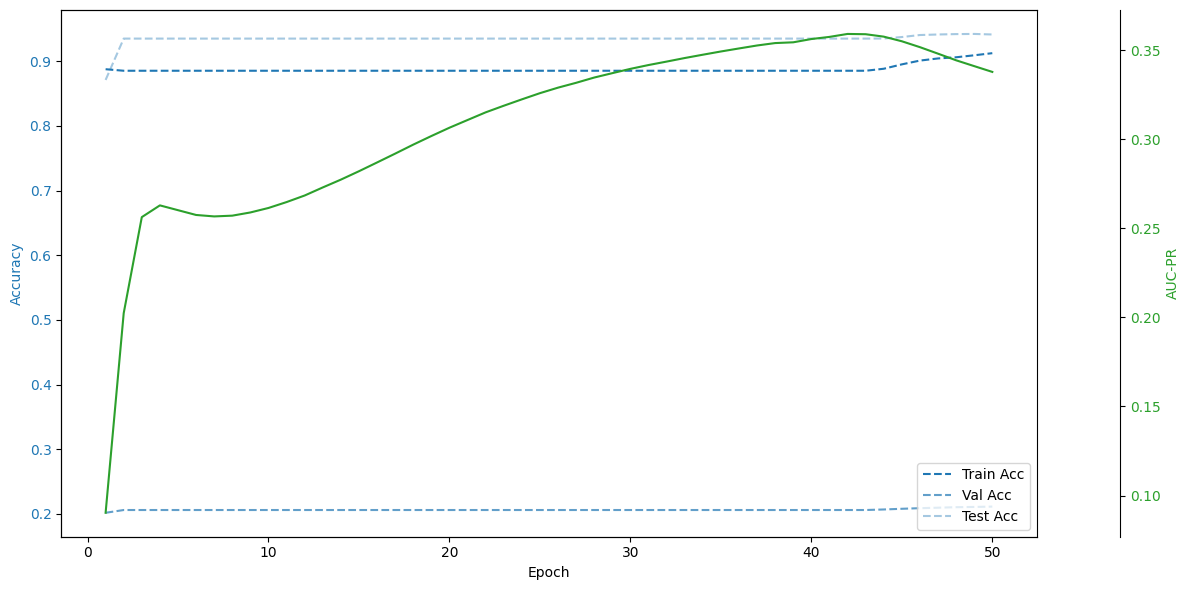

In [163]:
data = elip_data_mod
hidden_channels = 200
num_features = data.num_features+1
num_classes = get_num_classes(data)

model2 = GCN(num_features, hidden_channels, num_classes)
optimizer2 = optim.Adam(model2.parameters(), lr=2e-3)
loss_fn = nn.CrossEntropyLoss()

optimizer2.zero_grad()

print("Elip Dataset")
evaluate_with_plot(elip_data_mod, model2, optimizer2, loss_fn)

## Evaluated on Cora

Cora Dataset
Epoch 001/050
Epoch 002/050
Epoch 003/050
Epoch 004/050
Epoch 005/050
Epoch 006/050
Epoch 007/050
Epoch 008/050
Epoch 009/050
Epoch 010/050
Epoch 011/050
Epoch 012/050
Epoch 013/050
Epoch 014/050
Epoch 015/050
Epoch 016/050
Epoch 017/050
Epoch 018/050
Epoch 019/050
Epoch 020/050
Epoch 021/050
Epoch 022/050
Epoch 023/050
Epoch 024/050
Epoch 025/050
Epoch 026/050
Epoch 027/050
Epoch 028/050
Epoch 029/050
Epoch 030/050
Epoch 031/050
Epoch 032/050
Epoch 033/050
Epoch 034/050
Epoch 035/050
Epoch 036/050
Epoch 037/050
Epoch 038/050
Epoch 039/050
Epoch 040/050
Epoch 041/050
Epoch 042/050
Epoch 043/050
Epoch 044/050
Epoch 045/050
Epoch 046/050
Epoch 047/050
Epoch 048/050
Epoch 049/050
Epoch 050/050
Flickr Dataset
Epoch 010/050 | Loss: 0.4415 | Train Acc: 0.8571 | Val Acc: 0.8860 | Test Acc: 0.8970 | AUC-PR: 0.4628
Epoch 020/050 | Loss: 0.3887 | Train Acc: 0.9500 | Val Acc: 0.9160 | Test Acc: 0.9180 | AUC-PR: 0.8025
Epoch 030/050 | Loss: 0.3436 | Train Acc: 1.0000 | Val Acc: 0.9620

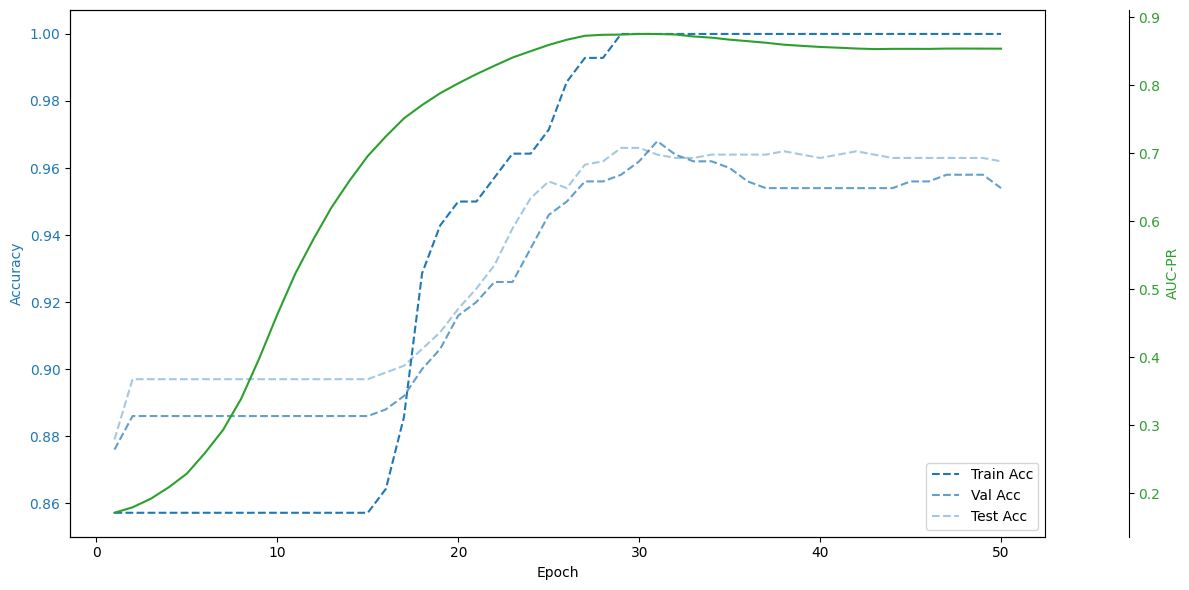

In [38]:
data = cora_data
n_hidden = 256
dropout = 0.5
num_features = data.num_features
model = SVDAE(
            num_layers = 1,
            in_feats = num_features,
            n_hidden = n_hidden,
            n_classes = data.num_classes,
            activation = nn.ReLU(inplace=True),
            dropout = dropout,
            n=0.1)
optimizer = optim.Adam(model.parameters(), lr=2e-3)




print("Cora Dataset")
score, ra, rs = evaluate_SVDAE(data, model, optimizer, hidden_channels, 0.9, 0.2, 0.2, 50, 1)


data_center_A, data_center_S, start, end = init_center_dual(n_hidden, model, data)
beta = 0.9
nu1 = nu2 = 0.2



outputs_A, outputs_S, rec, re_adj, start, end = model(data.x, data.edge_index, 0.1)
adj = generate_approx_adj(data, start, end, 0.1)

loss, _, _, scores = loss_function_dualAE(beta, nu1, nu2, rec, re_adj, adj, data.x,
                                                  data_center_A, data_center_S, outputs_A, outputs_S, ra,
                                                  rs)

scores = scores.view(-1, 1)

# Concatenate along the second dimension (columns)
result = torch.cat((cora_data.x, scores.detach()), dim=1)

cora_data_mod = Planetoid(root = root+ '/cora', name = "cora")
cora_data_mod.x = result
modified_labels = torch.where(cora_data_mod.y == 5, torch.tensor(1), torch.tensor(0))
cora_data_mod.y = modified_labels

data = cora_data_mod
hidden_channels = 200
num_features = data.num_features+1
num_classes = get_num_classes(data)

model2 = GCN(num_features, hidden_channels, num_classes)
optimizer2 = optim.Adam(model2.parameters(), lr=2e-3)
loss_fn = nn.CrossEntropyLoss()

optimizer2.zero_grad()

print("Flickr Dataset")
evaluate_with_plot(cora_data_mod, model2, optimizer2, loss_fn)

Epoch 010/050 | Loss: 0.3133
Epoch 020/050 | Loss: 0.3133
Epoch 030/050 | Loss: 0.3133
Epoch 040/050 | Loss: 0.3133
Epoch 050/050 | Loss: 0.3133


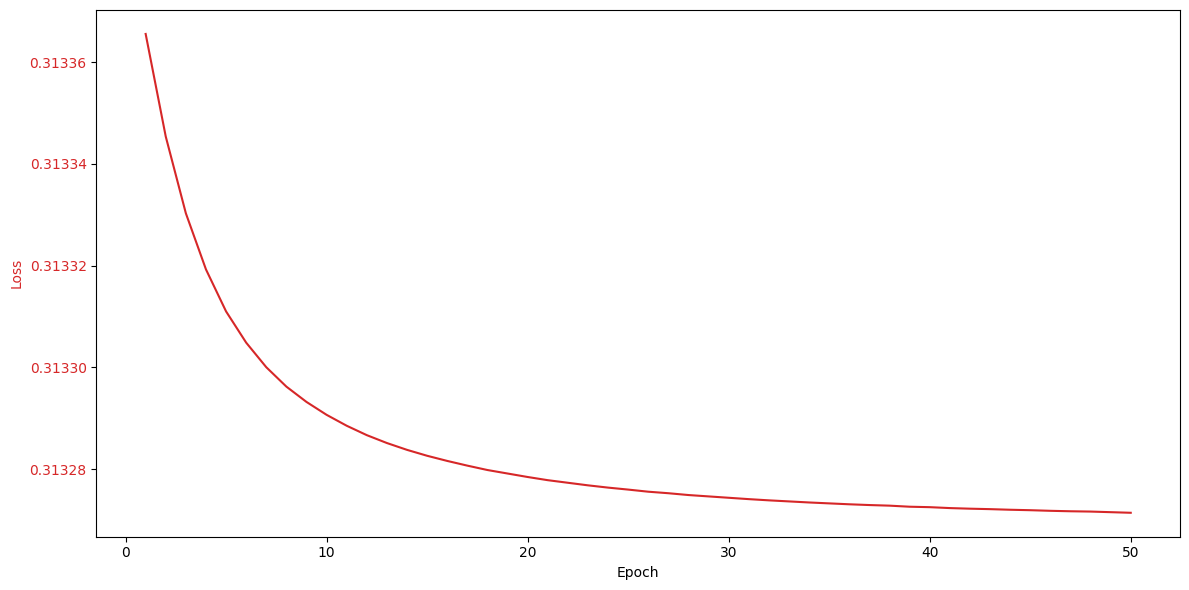

In [29]:
evaluate_with_loss(cora_data_mod, model2, optimizer2, loss_fn)